> __Content modified under Creative Commons Attribution license CC-BY
> 4.0, code under BSD 3-Clause License © 2020 R.C. Cooper__

# Get with the oscillations

So far, in this module you have learned to:

* capture time histories of a body's position from images and video;
* compute velocity and acceleration of a body, from known positions over time—i.e., take numerical derivatives;
* find the motion description (position versus time) from acceleration data, stepping in time with Euler's method;
* form the state vector and the vectorized form of a second-order dynamical system;
* improve the simple free-fall model by adding air resistance.

You also learned that Euler's method is a _first-order_ method: a Taylor series expansion shows that stepping in time with Euler makes an error—called the _truncation error_ —proportional to the time increment, $\Delta t$.

In this lesson, you'll work with oscillating systems. Euler's method
doesn't do very well with oscillating systems, but you'll show you a clever way to fix this. (The modified method is _still_ first order, however. You will also confirm the **order of convergence** by computing the error using different values of $\Delta t$.

As always, you will need our best-loved numerical Python libraries, and
you'll also re-use the `eulerstep()` function from the [previous lesson](http://go.gwu.edu/engcomp3lesson2). So let's get that out of the way.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 22})
plt.rcParams['lines.linewidth'] = 3

In [2]:
def eulerstep(state, rhs, dt):
    '''Update a state to the next time increment using Euler's method.
    
    Arguments
    ---------
    state : array of dependent variables
    rhs   : function that computes the RHS of the DiffEq
    dt    : float, time increment
    
    Returns
    -------
    next_state : array, updated after one time increment'''
    
    next_state = state + rhs(state) * dt
    return next_state

## Spring-mass system

A prototypical mechanical system is a mass $m$ attached to a spring, in the simplest case without friction. The elastic constant of the spring, $k$, determines the restoring force it will apply to the mass when displaced by a distance $x$. The system then oscillates back and forth around its position of equilibrium.

<img src="../images/spring-mass.png" style="width: 400px;"/>

## Simple spring-mass system, without friction.
Newton's law applied to the friction-less spring-mass system is:

\begin{equation}
-k x = m \ddot{x}
\end{equation}

Introducing the parameter $\omega = \sqrt{k/m}$, the equation of motion is rewriten as:

\begin{equation}
\ddot{x} + \omega^2 x = 0
\end{equation}

where a dot above a dependent variable denotes the time derivative. This is a second-order differential equation for the position $x$, having a known analytical solution that represents _simple harmonic motion_:

$x(t) = x_0 \cos(\omega t)$

The solution represents oscillations with period $P = 2 \pi/ \omega $  (the time between two peaks), and amplitude $x_0$.

### System in vector form

It's useful to write a second-order differential equation as a set of two first-order equations: in this case, for position and velocity, respectively:

\begin{eqnarray}
\dot{x} &=& v \nonumber\\
\dot{v} &=& -\omega^2 x
\end{eqnarray}

Like you did in [Lesson 2](./02_Step_Future.ipynb) of this module, you write the state of the system as a two-dimensional vector,

\begin{equation}
\mathbf{x} = \begin{bmatrix}
x \\ v
\end{bmatrix},
\end{equation}

and the differential equation in vector form:

\begin{equation}
\dot{\mathbf{x}} = \begin{bmatrix}
v \\ -\omega^2 x
\end{bmatrix}.
\end{equation}

Several advantages come from writing the differential equation in vector form, both  theoretical and practical. In the study of dynamical systems, for example, the state vector lives in a state space called the _phase plane_, and many things can be learned from studying solutions to differential equations graphically on a phase plane.

Practically, writing the equation in vector form results in more general, compact code. Let's write a function to obtain the right-hand side of the spring-mass differential equation, in vector form.

In [3]:
def springmass(state):
    '''Computes the right-hand side of the spring-mass differential 
    equation, without friction.
    
    Arguments
    ---------   
    state : array of two dependent variables [x v]^T
    
    Returns 
    -------
    derivs: array of two derivatives [v - w*w*x]^T
    '''
    
    derivs = np.array([state[1], -w**2*state[0]])
    return derivs

This worked example follows Reference [1], section 4.3 (note that the source is open access). You set the parameters of the system, choose a time interval equal to 1-20th of the oscillation period, and decide to solve the motion for a duration equal to 3 periods.

In [4]:
w = 2
period = 2*np.pi/w
dt = period/200  # you choose 20 time intervals per period 
T = 3*period    # solve for 3 periods
N = round(T/dt)

In [5]:
print(N)
print(dt)

600
0.015707963267948967


Next, set up the time array and initial conditions, initialize the solution array with zero values, and assign the initial values to the first elements of the solution array.

In [6]:
t = np.linspace(0, T, N)

In [7]:
x0 = 2    # initial position
v0 = 0    # initial velocity

In [8]:
#initialize solution array
num_sol = np.zeros([N,2])

In [9]:
#Set intial conditions
num_sol[0,0] = x0
num_sol[0,1] = v0

You're ready to solve! Step through the time increments, calling the `eulerstep()` function with the `springmass` right-hand-side derivatives and time increment as inputs.

In [10]:
for i in range(N-1):
    num_sol[i+1] = eulerstep(num_sol[i], springmass, dt)

Now, let's compute the position with respect to time using the known analytical solution, so that you can compare the numerical result with it. Below, you make a plot including both numerical and analytical values in our chosen time range.

In [11]:
x_an = x0*np.cos(w * t)

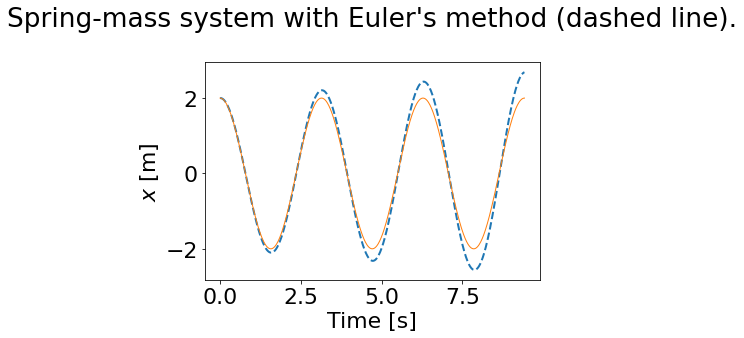

In [12]:
# plot solution with Euler's method
fig = plt.figure(figsize=(6,4))

plt.plot(t, num_sol[:, 0], linewidth=2, linestyle='--', label='Numerical solution')
plt.plot(t, x_an, linewidth=1, linestyle='-', label='Analytical solution')
plt.xlabel('Time [s]')
plt.ylabel('$x$ [m]')
plt.title('Spring-mass system with Euler\'s method (dashed line).\n');

Yikes! The numerical solution exhibits a marked growth in amplitude over time, which certainly is not what the physical system displays. _What is wrong with Euler's method?_

##### Exercise: 

* Try repeating the calculation above using smaller values of the time increment, `dt`, and see if the results improve. Try `dt=P/40`,  `P/160` and  `P/2000`.

* Although the last case, with 2000 steps per oscillation, does look good enough, see what happens if you then increase the time of simulation, for example to 20 periods. —Run the case again: _What do you see now?_

Observe a growth in amplitude in the numerical solution, worsening over
time. The solution does improve when you reduce the time increment `dt`
(as it should), but the amplitude still displays unphysical growth for
longer simulations.

## Euler-Cromer method

The thing is, Euler's method has a fundamental problem with oscillatory systems. Look again at the approximation made by Euler's method to get the position at the next time interval:

\begin{equation}
 x(t_i+\Delta t)   \approx  x(t_i) + v(t_i) \Delta t
\end{equation}

It uses the velocity value at the _beginning_ of the time interval to step the solution to the future. 

A graphical explanation can help here. Remember that the derivative of a function corresponds to the slope of the tangent at a point. Euler's method approximates the derivative using the slope at the initial point in an interval, and advances the numerical position with that initial velocity. The sketch below illustrates two consecutive Euler steps on a function with high curvature.

<img src="../images/two-euler-steps.png" style="width: 500px;"/> 

#### Sketch of two Euler steps on a curved function.

Since Euler's method makes a linear approximation to project the solution into the future, assuming the value of the derivative at the start of the interval, it's not very good on oscillatory functions.

A clever idea that improves on Euler's method is to use the updated value of the derivatives for the _second_ equation.

Pure Euler's method applies:

\begin{eqnarray}
x(t_0) = x_0, \qquad x_{i+1} &=& x_i + v_i \Delta t \nonumber\\
v(t_0) = v_0, \qquad v_{i+1} &=& v_i - {\omega}^2 x_i \Delta t
\end{eqnarray}

What if in the equation for $v$ you used the value $x_{i+1}$ that was just computed? Like this:

\begin{eqnarray}
x(t_0) = x_0, \qquad x_{i+1} &=& x_i + v_i \Delta t \nonumber\\
v(t_0) = v_0, \qquad v_{i+1} &=& v_i - {\omega}^2 x_{i+1} \Delta t
\end{eqnarray}

Notice the $x_{i+1}$ on the right-hand side of the second equation: that's the updated value, giving the acceleration at the _end_ of the time interval. This modified scheme is called Euler-Cromer method, to honor clever Mr Cromer, who came up with the idea [2].

Let's see what it does. Study the function below carefully—it helps a lot if you write things out on a piece of paper!

In [13]:
def euler_cromer(state, rhs, dt):
    '''Update a state to the next time increment using Euler-Cromer's method.
    
    Arguments
    ---------
    state : array of dependent variables
    rhs   : function that computes the RHS of the DiffEq
    dt    : float, time increment
    
    Returns
    -------
    next_state : array, updated after one time increment'''
    
    mid_state = state + rhs(state)*dt # Euler step
    mid_derivs = rhs(mid_state)       # updated derivatives
    
    next_state = np.array([mid_state[0], state[1] + mid_derivs[1]*dt])
    
    return next_state

You've copied the whole problem set-up below, to get the solution in one
code cell, for easy trial with different parameter choices. Try it out!

In [14]:
w = 2
period = 2*np.pi/w
dt = period/200  # time intervals per period 
T = 800*period   # simulation time, in number of periods
N = round(T/dt)

print('The number of time steps is {}.'.format( N ))
print('The time increment is {}'.format( dt ))

# time array
t = np.linspace(0, T, N)

x0 = 2    # initial position
v0 = 0    # initial velocity

#initialize solution array
num_sol = np.zeros([N,2])

#Set intial conditions
num_sol[0,0] = x0
num_sol[0,1] = v0

for i in range(N-1):
    num_sol[i+1] = euler_cromer(num_sol[i], springmass, dt)

The number of time steps is 160000.
The time increment is 0.015707963267948967


Recompute the analytical solution, and plot it alongside the numerical
one, when you're ready. You computed a crazy number of oscillations, so
you'll need to pick carefully the range of time to plot.

First, get the analytical solution. You chose to then plot the first few periods of the oscillatory motion: numerical and analytical.

In [15]:
x_an = x0*np.cos(w * t) # analytical solution

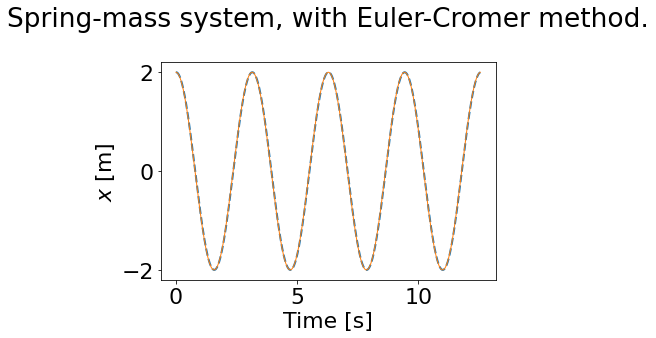

In [16]:
iend = 800 # in number of time steps

fig = plt.figure(figsize=(6,4))

plt.plot(t[:iend], num_sol[:iend, 0], linewidth=2, linestyle='--', label='Numerical solution')
plt.plot(t[:iend], x_an[:iend], linewidth=1, linestyle='-', label='Analytical solution')
plt.xlabel('Time [s]')
plt.ylabel('$x$ [m]')
plt.title('Spring-mass system, with Euler-Cromer method.\n');

The plot shows that Euler-Cromer does not have the problem of growing
amplitudes. You should be happy with it in that sense.

But if you plot the end of a long period of simulation, you can see that it does start to  deviate from the analytical solution.

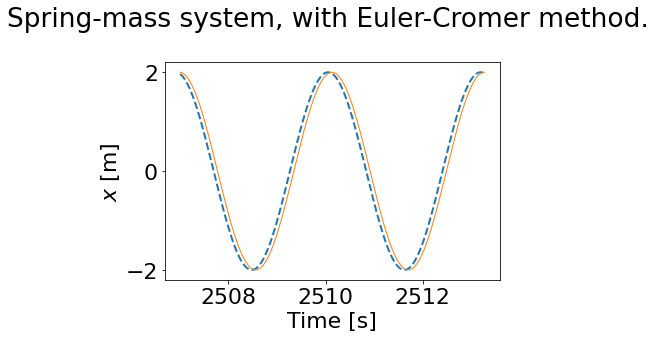

In [17]:
istart = 400

fig = plt.figure(figsize=(6,4))

plt.plot(t[-istart:], num_sol[-istart:, 0], linewidth=2, linestyle='--', label='Numerical solution')
plt.plot(t[-istart:], x_an[-istart:], linewidth=1, linestyle='-', label='Analytical solution')
plt.xlabel('Time [s]')
plt.ylabel('$x$ [m]')
plt.title('Spring-mass system, with Euler-Cromer method. \n');

Looking at the last few oscillations in a very long run shows a slight phase difference, even with a very small time increment. So although the Euler-Cromer method fixes a big problem with Euler's method, it still has some error. It's still a first-order method!

#### The Euler-Cromer method is first-order accurate, just like Euler's method. The global error is proportional to $\Delta t$.

##### Note:

You'll often find the presentation of the Euler-Cromer method with the reverse order of the equations, i.e., the velocity equation solved first, then the position equation solved with the updated value of the velocity. This makes no difference in the results: it's just a convention among physicists.

The Euler-Cromer method is equivalent to a [_semi-implicit Euler method_](https://en.wikipedia.org/wiki/Semi-implicit_Euler_method).

## Convergence

Both Euler's method and the Cromer variant are _first-order accurate_: the error goes as the first power of $\Delta t$. In [Lesson 2](http://go.gwu.edu/engcomp3lesson2) of this module, you showed this using a Taylor series. Let's now confirm it numerically.

Because simple harmonic motion has a known analytical function that solves the differential equation, you can directly compute a measure of the error made by the numerical solution. 

Suppose you ran a numerical solution in the interval from $t_0$ to $T=N/\Delta t$. You could then compute the error, as follows:

\begin{equation}
e = x_N - x_0 \cos(\omega T)
\end{equation}

where $x_N$ represents the numerical solution at the $N$-th time step.

How could you confirm the order of convergence of a numerical method? In the lucky scenario of having an analytical solution to directly compute the error, all you need to do is solve numerically with different values of $\Delta t$ and see if the error really varies linearly with this parameter.

In the code cell below, you compute the numerical solution with different time increments. You use two nested `for`-statements: one iterates over the values of $\Delta t$, and the other iterates over the time steps from the initial condition to the final time. You save the results in a new variable called `num_sol_time`, which is an array of arrays. Check it out!

In [18]:
dt_values = np.array([period/50, period/100, period/200, period/400])
T = 1*period

num_sol_time = np.empty_like(dt_values, dtype=np.ndarray)


for j, dt in enumerate(dt_values):

    N = int(T/dt)
    t = np.linspace(0, T, N)
    
    #initialize solution array
    num_sol = np.zeros([N,2])
    
    
    #Set intial conditions
    num_sol[0,0] = x0
    num_sol[0,1] = v0
    
    for i in range(N-1):
        num_sol[i+1] = eulerstep(num_sol[i], springmass, dt)

    num_sol_time[j] = num_sol.copy()

You need to compute the error with our chosen norm, so let's write a function for that. It includes a line to obtain the values of the analytical solution at the needed instant of time, and then it takes the difference with the numerical solution to compute the error.

In [19]:
def get_error(num_sol, T):
    
    x_an = x0 * np.cos(w * T) # analytical solution at final time
    
    error =  np.abs(num_sol[-1,0] - x_an)
    
    return error

All that is left to do is to call the error function with our chosen values of $\Delta t$, and plot the results. A logarithmic scale on the plot confirms close to linear scaling between error and time increment.

In [20]:
error_values = np.empty_like(dt_values)

for j in range(len(dt_values)):
    
    error_values[j] = get_error(num_sol_time[j], T)

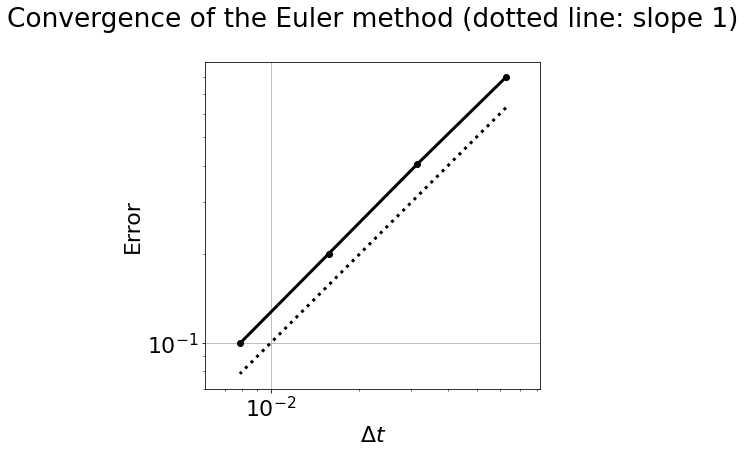

In [21]:
# plot the solution errors with respect to the time incremetn
fig = plt.figure(figsize=(6,6))

plt.loglog(dt_values, error_values, 'ko-')  #log-log plot
plt.loglog(dt_values, 10*dt_values, 'k:')
plt.grid(True)                         #turn on grid lines
plt.axis('equal')                      #make axes scale equally
plt.xlabel('$\Delta t$')
plt.ylabel('Error')
plt.title('Convergence of the Euler method (dotted line: slope 1)\n');

What do you see in the plot of the error as a function of $\Delta t$? It looks like a straight line, with a slope close to 1. On a log-log convergence plot, a slope of 1 indicates that you have a first-order method: the error scales as ${\mathcal O}(\Delta t)$—using the "big-O" notation. It means that the error is proportional to the time increment: $ error \propto \Delta t.$

## Modified Euler's method

Another improvement on Euler's method is achieved by stepping the numerical solution to the midpoint of a time interval, computing the derivatives there, and then going back and updating the system state using the midpoint derivatives. This is called _modified Euler's method_.

If you write the vector form of the differential equation as: 

\begin{equation}
\dot{\mathbf{x}} = f(\mathbf{x}),
\end{equation}

then modified Euler's method is:
\begin{align}
\mathbf{x}_{n+1/2}   & = \mathbf{x}_n + \frac{\Delta t}{2} f(\mathbf{x}_n) \\
\mathbf{x}_{n+1} & = \mathbf{x}_n + \Delta t \,\, f(\mathbf{x}_{n+1/2}).
\end{align}

Now write a Python function to update the state using this method. It's equivalent to a so-called _Runge-Kutta second-order_ method, so you call it `rk2_step()`.

In [22]:
def rk2_step(state, rhs, dt):
    '''Update a state to the next time increment using modified Euler's method.
    
    Arguments
    ---------
    state : array of dependent variables
    rhs   : function that computes the RHS of the DiffEq
    dt    : float, time increment
    
    Returns
    -------
    next_state : array, updated after one time increment'''
    
    mid_state = state + rhs(state) * dt*0.5    
    next_state = state + rhs(mid_state)*dt
 
    return next_state

Let's see how it performs with our spring-mass model.

In [23]:
dt_values = np.array([period/50, period/100, period/200,period/400,period/1000])
T = 1*period

num_sol_time = np.empty_like(dt_values, dtype=np.ndarray)


for j, dt in enumerate(dt_values):

    N = int(T/dt)
    t = np.linspace(0, T, N)
    
    #initialize solution array
    num_sol = np.zeros([N,2])
    
    
    #Set intial conditions
    num_sol[0,0] = x0
    num_sol[0,1] = v0
    
    for i in range(N-1):
        num_sol[i+1] = rk2_step(num_sol[i], springmass, dt)

    num_sol_time[j] = num_sol.copy()

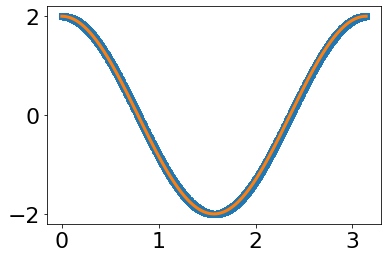

In [24]:
plt.plot(t,num_sol[:,0],'s')
plt.plot(t,x0*np.cos(w*t))

In [25]:
error_values = np.empty_like(dt_values)

for j, dt in enumerate(dt_values):
    
    error_values[j] = get_error(num_sol_time[j], T)

In [26]:
print(error_values)

[0.05230551 0.01439342 0.003771   0.00096474 0.00015649]


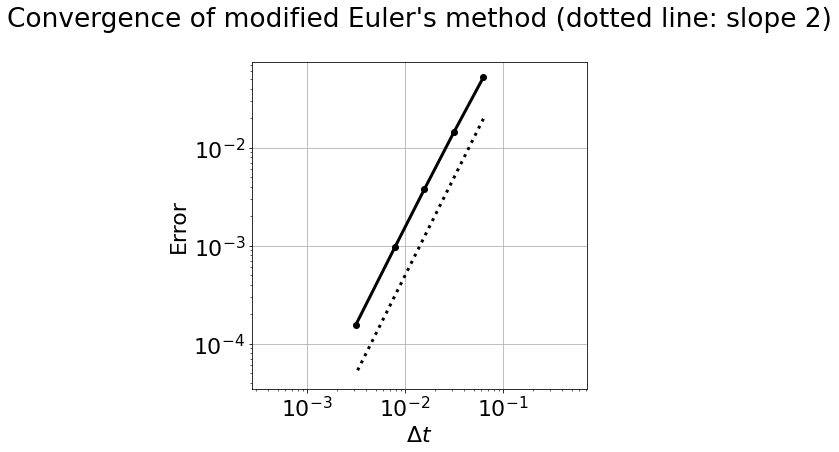

In [27]:
# plot of convergence for modified Euler's
fig = plt.figure(figsize=(6,6))

plt.loglog(dt_values, error_values, 'ko-')
plt.loglog(dt_values, 5*dt_values**2, 'k:')
plt.grid(True)
plt.axis('equal')
plt.xlabel('$\Delta t$')
plt.ylabel('Error')
plt.title('Convergence of modified Euler\'s method (dotted line: slope 2)\n');

The convergence plot, in this case, does look close to a slope-2 line. Modified Euler's method is second-order accurate: 
the effect of computing the derivatives (slope) at the midpoint of the time interval, instead of the starting point, is to increase the accuracy by one order!

Using the derivatives at the midpoint of the time interval is equivalent to using the average of the derivatives at $t$ and $t+\Delta t$: 
this corresponds to a second-order _Runge-Kutta method_, or RK2, for short.
Combining derivatives evaluated at different points in the time interval is the key to Runge-Kutta methods that achieve higher orders of accuracy.

## An implicit integration approach

In the Modified Euler's method, which is a type of second order Runge-Kutta method, you increased the accuracy of the method by approximating the average slope over the time step. The Euler method assumes the slope is constant during each time step. You can increase accuracy the accuracy of our average slope with an _implicit_ *predictor-corrector approach*. 

Heun's method is an integration method that uses the same second order Runge Kutta method, but with one important distinction. It uses the actual derivative at the next state as part of its correction. 

$y_{i+1}=y_{i}+f(t_{i},y_{i}) \Delta t$

$y_{i+1}=y_{i}+
\frac{f(t_{i},y_{i})+f(t_{i+1},y_{i+1})}{2} \Delta t$

The error is $ error \propto \Delta t^2.$ This is the same convergence as the Modified Euler's method. Let's compare the two methods.

## Using Heun's method

The problem with an _implicit_ method is that our unknown $\mathbf{y}_{i+1}$ is on both sides of the equation. In an _explicit_ method (such as the Euler and Modified Euler) you estimate the next state, with an equation that is only based upon the current state as such

$\mathbf{y}_{i+1} = f(\mathbf{y_{i}}),$

but with an implicit method you have a nonlinear function where

$\mathbf{y}_{i+1} = g(\mathbf{y}_{i},\mathbf{y}_{i+1}). $

This extra step introduces the topic of solving a nonlinear problem with
a computer. How can you solve an equation if the value you want is also
part of our function? You'll take a look at methods to solve this next
module, but for now lets set a tolerance `etol` for the _implicit_ Heun
method and see what the resulting solution is.

In [28]:
def heun_step(state,rhs,dt,etol=0.000001,maxiters = 100):
    '''Update a state to the next time increment using the implicit Heun's method.
    
    Arguments
    ---------
    state : array of dependent variables
    rhs   : function that computes the RHS of the DiffEq
    dt    : float, time increment
    etol  : tolerance in error for each time step corrector
    maxiters: maximum number of iterations each time step can take
    
    Returns
    -------
    next_state : array, updated after one time increment'''
    e=1
    eps=np.finfo('float64').eps
    next_state = state + rhs(state)*dt
    ################### New iterative correction #########################
    for n in range(0,maxiters):
        next_state_old = next_state
        next_state = state + (rhs(state)+rhs(next_state))/2*dt
        e=np.sum(np.abs(next_state-next_state_old)/np.abs(next_state+eps))
        if e<etol:
            break
    ############### end of iterative correction #########################
    return next_state

## Why use implicit methods?

The __benefit__ of an implicit solution is that it is a __stable__ solution. When you solve a set of differential equations, many times it may not be apparent what time step to choose. If you use an _implicit_ integration method, then it may converge at the same rate as an _explicit_ method, but it will always provide bounded errors. 

Consider the spring-mass equation if timesteps are large, in this case you have 10 steps/time period, then the second order Runge-Kutta that you defined above has the same increasing error as the Euler method.

In [29]:
w = 2
period = 2*np.pi/w
dt = period/10  # time intervals per period 
T = 8*period   # simulation time, in number of periods
N = round(T/dt)

print('The number of time steps is {}.'.format( N ))
print('The time increment is {}'.format( dt ))

# time array
t = np.linspace(0, T, N)

x0 = 2    # initial position
v0 = 0    # initial velocity

#initialize solution array
num_heun = np.zeros([N,2])
num_rk2 = np.zeros([N,2])

#Set intial conditions
num_heun[0,0] = x0
num_heun[0,1] = v0
num_rk2[0,0] = x0
num_rk2[0,1] = v0

for i in range(N-1):
    num_heun[i+1] = heun_step(num_heun[i], springmass, dt)
    num_rk2[i+1] = rk2_step(num_rk2[i], springmass, dt)

The number of time steps is 80.
The time increment is 0.3141592653589793


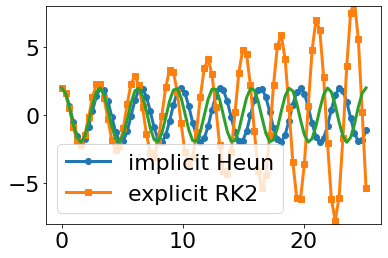

In [30]:
plt.plot(t,num_heun[:,0],'o-',label='implicit Heun')
plt.plot(t,num_rk2[:,0],'s-',label='explicit RK2')
plt.plot(t,x0*np.cos(w*t))
plt.ylim(-8,8)
plt.legend();
#plt.xlim(np.max(t)-5,np.max(t))
#plt.xlim(np.max(t)-period,np.max(t))

## Discussion

Change the number of steps per time period in the above solutions for the second order Runge Kutta and the implicit Heun's method. Why do you think the implicit method does not have an increasing magnitude of oscillation?

## What you've learned

* vector form of the spring-mass differential equation
* Euler's method produces unphysical amplitude growth in oscillatory systems
* the Euler-Cromer method fixes the amplitude growth (while still being first order)
* Euler-Cromer does show a phase lag after a long simulation
* a convergence plot confirms the first-order accuracy of Euler's method
* a convergence plot shows that modified Euler's method, using the derivatives evaluated at the midpoint of the time interval, is a second-order method
* How to create an implicit integration method
* The difference between _implicit_ and _explicit_ integration
* The difference between stable and unstable methods

## References

1. Linge S., Langtangen H.P. (2016) Solving Ordinary Differential Equations. In: Programming for Computations - Python. Texts in Computational Science and Engineering, vol 15. Springer, Cham, https://doi.org/10.1007/978-3-319-32428-9_4, open access and reusable under [CC-BY-NC](http://creativecommons.org/licenses/by-nc/4.0/) license.

2. Cromer, A. (1981). Stable solutions using the Euler approximation. _American Journal of Physics_, 49(5), 455-459. https://doi.org/10.1119/1.12478

3. Chapra, Steven, _Applied Numerical Methods with MATLAB for Engineers and Scientists_ 4th edition. ch. 22.3 Improvements to Euler's method

# Problems

1. Show that the implicit Heun's method has the same second order convergence as the Modified Euler's method. _Hint: you can use the same code from above to create the log-log plot to get the error between $2\cos(\omega t)$ and the `heun_step` integration. Use the same initial conditions x(0) = 2 m and v(0)=0m/s and the same RHS function, `springmass`._

In [31]:
def heun_step(state,rhs,dt,etol=0.000001,maxiters = 100):
    e=1
    eps=np.finfo('float64').eps
    next_state = state + rhs(state)*dt
    ################### New iterative correction #########################
    for n in range(0,maxiters):
        next_state_old = next_state
        next_state = state + (rhs(state)+rhs(next_state))/2*dt
        e=np.sum(np.abs(next_state-next_state_old)/np.abs(next_state+eps))
        if e<etol:
            break
    ############### end of iterative correction #########################
    return next_state

In [32]:
dt_values = np.array([period/50, period/100, period/200,period/400,period/1000])
T = 1*period

num_heun_time = np.empty_like(dt_values, dtype=np.ndarray)


for j, dt in enumerate(dt_values):

    N = int(T/dt)
    t = np.linspace(0, T, N)
    
    x0 = 2    # initial position
    v0 = 0    # initial velocity
    
    #initialize solution array
    num_heun = np.zeros([N,2])
    
    
    #Set intial conditions
    num_heun[0,0] = x0
    num_heun[0,1] = v0
    
    for i in range(N-1):
        num_heun[i+1] = heun_step(num_heun[i], springmass, dt)

    num_heun_time[j] = num_heun.copy()

In [33]:
heun_error_values = np.empty_like(dt_values)

for j, dt in enumerate(dt_values):
    
    heun_error_values[j] = get_error(num_heun_time[j], T)

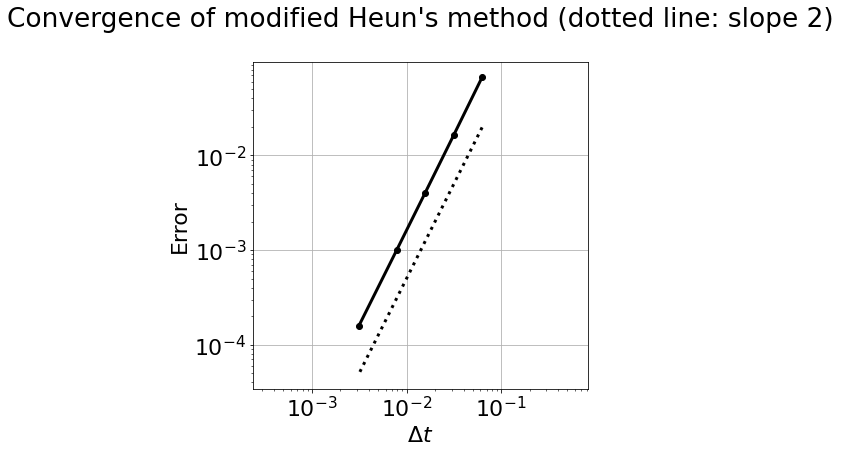

In [34]:
# plot of convergence for Heun
fig = plt.figure(figsize=(6,6))

plt.loglog(dt_values, heun_error_values, 'ko-')
plt.loglog(dt_values, 5*dt_values**2, 'k:')
plt.grid(True)
plt.axis('equal')
plt.xlabel('$\Delta t$')
plt.ylabel('Error')
plt.title('Convergence of modified Heun\'s method (dotted line: slope 2)\n');

The work above shows that the implicit Heun's method has the same second order convergence as the Modified Euler's method we saw previously. The dashed line is a reference of a second order function on the log-log plot. Since the slope of our error line approximately matches this, it shows that the error convergence of our Heun's method is a second order function.

<img src="../images/damped-spring.png" style="width: 400px;"/>

2. In the image above, you have a spring, mass, _and damper_. A damper is designed to slow down a moving object. These devices are typical in automobiles, mountain bikes, doors, any place where oscillations may not be desired, but motion is required. The new differential equation, if F(t)=0, that results from this addition is

$\ddot{x} = -\frac{b}{m}\dot{x} -\frac{k}{m}x$

or keeping our _natural frequency_ above, 

$\ddot{x} = -\zeta\omega\dot{x} -\omega^2x$

where $\zeta$ is a new constant called the __damping ratio__ of a system. When $\zeta\gt 1$, there are no oscillations and when $0<\zeta<1$ the system oscillates, but decays to v=0 m/s eventually. 

Create the system of equations that returns the right hand side (RHS) of the state equations, e.g. $\mathbf{\dot{y}} = f(\mathbf{y}) = RHS$

Use $\omega = 2$ rad/s and $\zeta = 0.2$.

In [35]:
def smd(state):
    '''Computes the right-hand side of the spring-mass-damper
    differential equation, without friction.
    
    Arguments
    ---------   
    state : array of two dependent variables [x, v]^T
    
    Returns 
    -------
    derivs: array of two derivatives [v, zeta*w*v - w*w*x]^T
    '''
    derivs = np.array([state[1], -z*w*state[1]-w**2*state[0]])
    
    return derivs

In [36]:
w = 2
z = 0.2
smd([2,0])

array([ 0., -8.])

3. Use three methods to integrate your `smd` function for 3 time periods of oscillation ( $t=0...6\pi$ ) and initial conditions x(0)=2 m and v(0)=0 m/s. Plot the three solutions on one graph with labels. 

a. Euler integration

b. second order Runge Kutta method (modified Euler method)

c. the implicit Heun's method

How many time steps does each method need to converge to the same results? _Remember that each method has a certain convergence rate_

In [37]:
x0 = 2
v0 = 0
w = 2
z = 0.2

In [38]:
period = 2*np.pi/w
dt = period/40
T = 3*period
N = round(T/dt)

t = np.linspace(0,T,N)

smd_euler = np.zeros([N,2])
smd_euler[0,0] = x0
smd_euler[0,1] = v0

smd_eulercromer = np.zeros([N,2])
smd_eulercromer[0,0] = x0
smd_eulercromer[0,1] = v0

smd_rk2 = np.zeros([N,2])
smd_rk2[0,0] = x0
smd_rk2[0,1] = v0

smd_heun = np.zeros([N,2])
smd_heun[0,0] = x0
smd_heun[0,1] = v0


for i in range(N-1):
    smd_euler[i+1] = eulerstep(smd_euler[i], smd, dt)
    smd_eulercromer[i+1] = euler_cromer(smd_eulercromer[i], smd, dt)
    smd_rk2[i+1] = rk2_step(smd_rk2[i], smd, dt)
    smd_heun[i+1] = heun_step(smd_heun[i], smd, dt)

In [39]:
x_smd2 = np.exp(-0.2*t)*(0.2*np.sin(2*t)+2*np.cos(2*t))

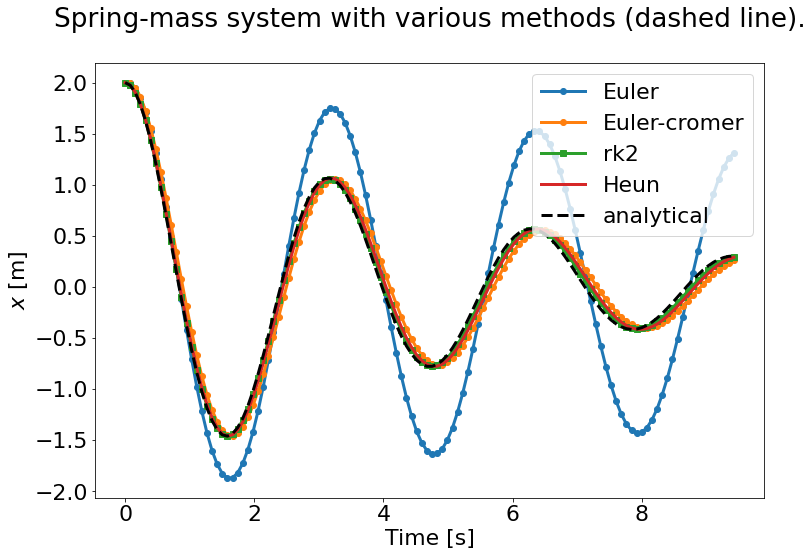

In [40]:
fig = plt.figure(figsize=(12,8))
plt.plot(t, smd_euler[:,0], 'o-', label='Euler')
plt.plot(t, smd_eulercromer[:,0], 'o-', label='Euler-cromer')
plt.plot(t, smd_rk2[:,0], 's-', label='rk2')
plt.plot(t, smd_heun[:,0], '-', label='Heun')
plt.plot(t, x_smd2, '--', color='k', label='analytical')
plt.title('Spring-mass system with various methods (dashed line).\n')
plt.xlabel('Time [s]')
plt.ylabel('$x$ [m]')
plt.legend();

In [41]:
values1 = np.linspace(20,200,4)
values2 = np.linspace(400, 4000, 10)
values3 = np.linspace(8000, 32000, 4)
values = np.concatenate((values1, values2, values3), axis=None)
dt_values = period/values

In [42]:
T = 3*period

smd_euler_time = np.empty_like(dt_values, dtype=np.ndarray)
smd_eulercromer_time = np.empty_like(dt_values, dtype=np.ndarray)
smd_rk2_time = np.empty_like(dt_values, dtype=np.ndarray)
smd_heun_time = np.empty_like(dt_values, dtype=np.ndarray)


for j, dt in enumerate(dt_values):

    N = int(T/dt)
    t = np.linspace(0, T, N)
    
    #initialize solution array
    smd_euler = np.zeros([N,2])
    smd_eulercromer = np.zeros([N,2])
    smd_rk2 = np.zeros([N,2])
    smd_heun = np.zeros([N,2])
    
    #Set intial conditions
    smd_euler[0,0] = x0
    smd_euler[0,1] = v0
    smd_eulercromer[0,0] = x0
    smd_eulercromer[0,1] = v0
    smd_rk2[0,0] = x0
    smd_rk2[0,1] = v0
    smd_heun[0,0] = x0
    smd_heun[0,1] = v0
    
    
    for i in range(N-1):
        smd_euler[i+1] = eulerstep(smd_euler[i], smd, dt)
        smd_eulercromer[i+1] = euler_cromer(smd_eulercromer[i], smd, dt)
        smd_rk2[i+1] = rk2_step(smd_rk2[i], smd, dt)
        smd_heun[i+1] = heun_step(smd_heun[i], smd, dt)

        
    smd_euler_time[j] = smd_euler.copy()
    smd_eulercromer_time[j] = smd_eulercromer.copy()
    smd_rk2_time[j] = smd_rk2.copy()
    smd_heun_time[j] = smd_heun.copy()

In [43]:
def smd_error(num_sol, T):
    
    x_smd_an = np.exp(-0.2*T)*(0.2*np.sin(2*T)+2*np.cos(2*T)) # analytical solution at final time
    
    error =  np.abs(num_sol[-1,0] - x_smd_an)
    
    return error

The analytical solution seen above was found using Wolfram Mathmatica differential equation solver

In [44]:
error_smd_euler = np.empty_like(dt_values)
error_smd_eulercromer = np.empty_like(dt_values)
error_smd_rk2 = np.empty_like(dt_values)
error_smd_heun = np.empty_like(dt_values)

for j, dt in enumerate(dt_values):
    
    error_smd_euler[j] = smd_error(smd_euler_time[j], T)
    error_smd_eulercromer[j] = smd_error(smd_eulercromer_time[j], T)
    error_smd_rk2[j] = smd_error(smd_rk2_time[j], T)
    error_smd_heun[j] = smd_error(smd_heun_time[j], T)

In [45]:
print(error_smd_euler)
print(error_smd_eulercromer)
print(error_smd_rk2)
print(error_smd_heun)

[4.59576069e+00 3.27151392e-01 1.54953609e-01 9.99361684e-02
 4.39905978e-02 1.89830853e-02 1.10516576e-02 7.15900061e-03
 4.84643985e-03 3.31425106e-03 2.22446789e-03 1.40965718e-03
 7.77408686e-04 2.72548595e-04 1.98903437e-03 3.11353997e-03
 3.48744777e-03 3.67422810e-03]
[0.1268189  0.01595516 0.00888969 0.00690993 0.00522904 0.00464534
 0.00448902 0.00441805 0.00437776 0.00435186 0.00433383 0.00432057
 0.0043104  0.00430236 0.00426726 0.00425035 0.00424481 0.00424206]
[0.00077684 0.0073104  0.00589358 0.00533918 0.00474252 0.00447489
 0.00439137 0.00435077 0.00432679 0.00431097 0.00429975 0.00429138
 0.0042849  0.00427973 0.00425665 0.00424522 0.00424143 0.00423954]
[0.0418359  0.00737034 0.0057761  0.00525419 0.00471319 0.00446684
 0.0043876  0.00434859 0.00432538 0.00430998 0.00429902 0.00429081
 0.00428445 0.00427936 0.00425663 0.00424522 0.00424143 0.00423954]


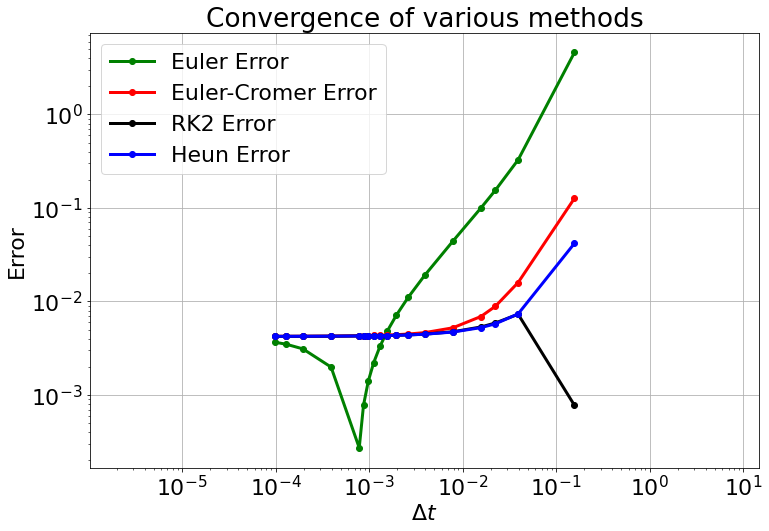

In [46]:
# plot of convergence
fig = plt.figure(figsize=(12,8))

plt.loglog(dt_values, error_smd_euler, 'go-', label='Euler Error')
plt.loglog(dt_values, error_smd_eulercromer, 'ro-', label='Euler-Cromer Error')
plt.loglog(dt_values, error_smd_rk2, 'ko-', label='RK2 Error')
plt.loglog(dt_values, error_smd_heun, 'bo-', label='Heun Error')
#plt.loglog(dt_values, dt_values, 'k:')
plt.grid(True)
plt.axis('equal')
plt.xlabel('$\Delta t$')
plt.ylabel('Error')
plt.title('Convergence of various methods')
plt.legend();

One question we were asked to analyze was, "How many time steps does each method need to converge to the same results?". Our least precise numerical solver, the standard Euler method, did not achieve an error much less than 1x10^-3, even when using the smallest time steps. So, we will select 1x10^-3 as our value, and analyze how many time steps each method requires to converge to this value. 

The standard Euler method converges to an error of approximately 1x10^-3 when using a dt of period/16000, which over 3 periods corresponds to a total of 48000 time steps.

The Euler-Cromer method converges to an error of approximately 1x10^-3 when using a dt of period/200, which over 3 periods corresponds to a total of 600 time steps.

The RK2 and Heun methods both converge to an error of approximately 1x10^-3 when using a dt of period/140, which over 3 periods corresponds to a total of 420 time steps. 

In general I believe the main point to take away from this exercise is that the RK2 and Heun methods converge to a reasonable error with relatively few time steps required. The Euler-Cromer method lags behind this and take a slightly smaller time step to reach the same error convergence. However, the standard Euler method takes an extremely smaller time step to reach the same error convergence as the other methods.

The smallest time step we used was period/32000, which is extremely small and took Jupyter almost 20 seconds to run. When using a time step this small, we observed that the standard Euler method converged to an error of 5.62366095e-04, the Euler-cromer method converged to an error of 5.46487304e-06, the RK2 method converged to an error of 2.94496682e-06, and the Heun method converged to an error of 2.94493885e-06.

Below is a quick plot of the solutions of the various numerical methods when using a very small time step. The plot is zoomed in very tightly to the end of the solution, which shows the error (mainly the difference between the standard Euler method and the other numerical methods).

In [47]:
period = 2*np.pi/w
dt = period/16000
T = 3*period
N = round(T/dt)

t = np.linspace(0,T,N)

smd_euler = np.zeros([N,2])
smd_euler[0,0] = x0
smd_euler[0,1] = v0

smd_eulercromer = np.zeros([N,2])
smd_eulercromer[0,0] = x0
smd_eulercromer[0,1] = v0

smd_rk2 = np.zeros([N,2])
smd_rk2[0,0] = x0
smd_rk2[0,1] = v0

smd_heun = np.zeros([N,2])
smd_heun[0,0] = x0
smd_heun[0,1] = v0


for i in range(N-1):
    smd_euler[i+1] = eulerstep(smd_euler[i], smd, dt)
    smd_eulercromer[i+1] = euler_cromer(smd_eulercromer[i], smd, dt)
    smd_rk2[i+1] = rk2_step(smd_rk2[i], smd, dt)
    smd_heun[i+1] = heun_step(smd_heun[i], smd, dt)

ValueError: x and y must have same first dimension, but have shapes (48000,) and (120,)

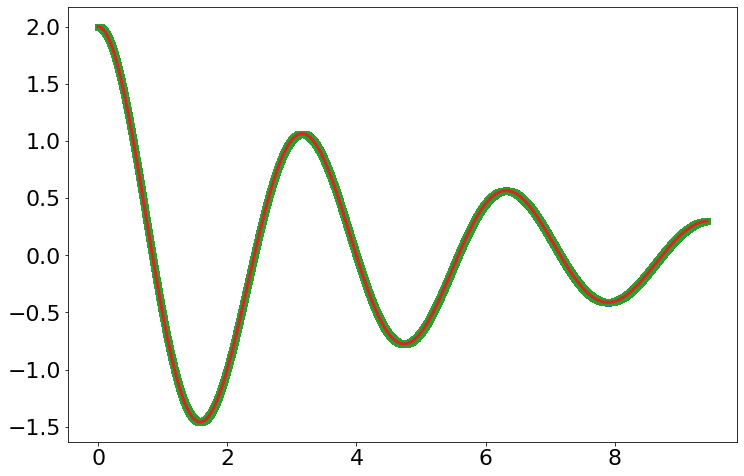

In [48]:
fig = plt.figure(figsize=(12,8))
plt.plot(t, smd_euler[:,0], 'o-', label='Euler')
plt.plot(t, smd_eulercromer[:,0], 'o-', label='Euler-cromer')
plt.plot(t, smd_rk2[:,0], 's-', label='rk2')
plt.plot(t, smd_heun[:,0], '-', label='Heun')
plt.plot(t, x_smd2, '--', color='k', label='analytical')
plt.title('Spring-mass system with various methods (dashed line).\n')
plt.xlabel('Time [s]')
plt.ylabel('$x$ [m]')
plt.xlim(9.42,9.43)
plt.ylim(0.295,0.305)
plt.legend();